<a href="https://colab.research.google.com/github/luoshaoyang/cs224w_final_proj/blob/main/Colab_FinalProj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Visible Masking/Watermark Removal with Graph Neural Network

In [1]:
from google.colab import drive
drive.mount('/content/drive')
FOLDERNAME = 'CS224WFinalProj/'
import sys
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))
%cd /content/drive/MyDrive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CS224WFinalProj


# Setup
* Import Libraries
* Handy Functions<br>
 1. loadImage
 2. image2NN
 3. NN2Image
 4. plotImage
 5. image2GrayScale
 6. image2Binary
 7. overlayerImg
 8. overlayImg1OverImg2
 9. addWatermark


In [2]:
# Packages
import numpy as np
import pandas as pd
import cv2
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt
import pickle

import torch
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device

In [3]:
# Functions
def loadImage(path,plotImg=True,gray_scale=False):
  #####################################################
  #Read in image path and returns an image
  #####################################################
  image = cv2.imread(path)
  image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY if gray_scale else cv2.COLOR_BGR2RGB)  
  if plotImg:
    plt.figure()
    plt.imshow(image)
    plt.show()
  return image

def image2Tensor(img,gray_scale=True):
  #####################################################
  #Read in image, and return tensor of the image
  #  more interesting reading: https://towardsdatascience.com/image-read-and-resize-with-opencv-tensorflow-and-pil-3e0f29b992be
  #####################################################
  # convert BGR image to RGB image
  img = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY if gray_scale else cv2.COLOR_BGR2RGB)
  transform = transforms.Compose([transforms.ToTensor()])
  img_tensor = transform(img)
  return img_tensor

def Tensor2Image(img_tensor,dim_order=None,gray_scale=True,plotImg=True):
  #####################################################
  #Read in tensor, and return plotable image
  #####################################################
  img = img_tensor.numpy()
  if dim_order:
    img = np.transpose(img,order)
  img = cvtColor(img,cv2.COLOR_BGR2GRAY if gray_scale else cv2.COLOR_BGR2RGB)
  if plotImg:
    plt.figure()
    plt.imshow(image)
    plt.show()
  return img

def plotImg(image):
  plt.figure()
  plt.imshow(image)
  plt.show()

def image2GrayScale(image):
  img = cvtColor(img,cv2.COLOR_BGR2GRAY)
  return img

def image2Binary(image):
  img = image2GrayScale(image)
  img = np.round(img)
  return img

def overlayerImg(size,rgb):
  #####################################################
  #Create a box overlay image that could go above the license plate
  #  rgb being a vector of shape (,3); size being a vector of shape (row,col,3)
  #####################################################
  img = np.ndarray([[[rgb[0]]*size.shape[0]]*size.shape[1],
                    [[rgb[1]]*size.shape[0]]*size.shape[1],
                    [[rgb[2]]*size.shape[0]]*size.shape[1]])
  return img

def overlayImg1OverImg2(img1,img2):
  #####################################################
  #Overlay the box image (img1) above the license plate(img2)
  #  center the images at the same place
  #####################################################
  img = img2.copy()
  y_lower = np.round(img.shape[0]/2)-np.round(img1.shape[0]/2)
  y_upper = y_lower+img1.shape[0]# (y_lower,y_upper]
  img[y_lower:y_upper,:,:] = img1
  return img

def addWatermark(img,watermark,wm_scale):
  #####################################################
  #Add watermark image on bottom right of the license plate(img)
  #  center the images at the same place
  #####################################################
  img_wm = img.copy()
  #prepare watermark image
  wm_size = (int(watermark.shape[1]*wm_scale),int(watermark.shape[0]*wm_scale))
  img_w = cv2.resize(watermark,wm_size,interpolation=cv2.INTER_AREA)
  #prepare cordinates
  h_img, w_img, _ = img.shape
  h_wm, w_wm, _ = img_w.shape
  bottom_y = h_img
  right_x = w_img
  top_y = bottom_y - int(h_wm)
  left_x = right_x - int(w_wm)
  #img[170:175, left_x:right_x]
  roi = img[top_y:bottom_y, left_x:right_x]
  result = cv2.addWeighted(roi, 1, img_w, 0.3, 0)
  img_wm[top_y:bottom_y, left_x:right_x] = result
  return img_wm

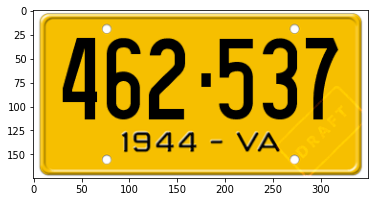

In [94]:
wm = addWatermark(img,watermark,wm_scale=0.04)
plt.imshow(wm)

#Data Processing
* Read in the datasets
* Create masked/watermarked datasets
* Split for training and testing

In [4]:
# Load DataSet
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test
# idx=0#for image 0 in training
# path = os.path.join('../data', train.loc[idx, 'Label'], train.loc[idx, 'Image'])
# loadImage(path)

,Label,Image
0,WashingtonDC,8e21ecfa6427ef.jpg
1,NewHampshire,c1e633601f1bc4.jpg
2,California,aeafb7d258eeb7.jpg
3,Tennessee,eed4b8d8e22dd9.jpg
4,Louisiana,77a3874c21281a.jpg
...,...,...
442,Utah,b13e4ec47aa127.jpg
443,WashingtonDC,8a9342d9b114b8.jpg
444,Vermont,d313026cffe30c.jpg
445,NewYork,9b702e5aca6c97.jpg


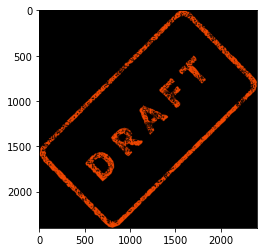

53c38343199dcd.jpg not exist, skip.
494d7d4ce15f68.jpg not exist, skip.
8f866d52b57e37.jpg not exist, skip.
a24e2fc2b715e5.jpg not exist, skip.
80c1fc108d175d.jpg not exist, skip.
11b682f9d482d3.jpg not exist, skip.
5.0% training data processed
043bcbd1e293fe.jpg not exist, skip.
d1a356a83cc632.jpg not exist, skip.
50f72a30fbbcca.jpg not exist, skip.
851d051a2358df.jpg not exist, skip.
4195ab943f9c70.jpg not exist, skip.


In [ ]:
# Create watermarked datasets: bottom right 100*100 pixels
watermark = loadImage("watermark.png")

train_wm={}#{file_name:img}
train_original={}#{file_name:img}
counter=0
img_file=train["Image"][0]
for img_file in train["Image"]:
  path = os.path.join('/content/drive/MyDrive/CS224WFinalProj/data',img_file)
  #path_wm = os.path.join('/content/drive/MyDrive/CS224WFinalProj/data/train/wm',img_file)
  #path_original = os.path.join('/content/drive/MyDrive/CS224WFinalProj/data/train/original',img_file)
  try:
    img = loadImage(path,plotImg=False)
    img_wm = addWatermark(img,watermark,wm_scale=0.04)
    train_original[img_file]=img.copy()
    train_wm[img_file]=img_wm.copy()
    # cv2.imwrite(path_original,img)
    # cv2.imwrite(path_wm,img_wm)
  except:
    print(f"{img_file} not exist, skip.")
    continue
  counter+=1
  if (counter*100/len(train))%5==0:
    print(f"{(counter*100/len(train))%10}% training data processed")
with open("train_wm.pkl","wb") as fl:
  pickle.dump(train_wm,fl)
  print("train_wm saved")
with open("train_original.pkl","wb") as fl:
  pickle.dump(train_original,fl)
  print("train_original saved")

counter=0
test_wm={}#{file_name:img}
test_original={}#{file_name:img}
for img_file in test["Image"]:
  path = os.path.join('/content/drive/MyDrive/CS224WFinalProj/data',img_file)
  #path_wm = os.path.join('/content/drive/MyDrive/CS224WFinalProj/data/test/wm',img_file)
  #path_original = os.path.join('/content/drive/MyDrive/CS224WFinalProj/data/test/original',img_file)
  try:
    img = loadImage(path,plotImg=False)
    img_wm = addWatermark(img,watermark,wm_scale=0.04)
    test_original[img_file]=img.copy()
    test_wm[img_file]=img_wm.copy()
    # cv2.imwrite(path_original,img)
    # cv2.imwrite(path_wm,img_wm)
  except:
    print(f"{img_file} not exist, skip.")
    continue
  if (counter*100/len(test))%5==0:
    print(f"{(counter*100/len(test))%10}% training data processed")
with open("test_wm.pkl","wb") as fl:
  pickle.dump(test_wm,fl)
  print("test_wm saved")
with open("test_original.pkl","wb") as fl:
  pickle.dump(test_original,fl)
  print("test_original saved")

# load pre-processed data
with open("train_wm.pkl","wb") as fl:
  train_wm=pickle.load(fl)
with open("train_original.pkl","wb") as fl:
  train_original=pickle.load(fl)
with open("test_wm.pkl","wb") as fl:
  test_wm=pickle.load(fl)
with open("test_original.pkl","wb") as fl:
  test_original=pickle.load(fl)

# Model Build
* Learn GNN embedding
* Apply GCN to predict<br>
  1. GCN training
  2. Accuracy measurement
* Apply label propagation to predict<br>
  1. Edge weight training
  2. propagation iteration
  3. Accuracy measurement

In [ ]:
# GNN embedding learning

In [ ]:
# GCN Model

In [ ]:
# Label Propagation
#####################################
#prepare edge_weight and nn graph
#- dict edge_weights = {(from_node_id,to_node_id):weight}
edge_weights = {
    (1,2):1,(2,1):1,
    (2,3):1,(3,2):1,
    (3,4):1,(4,3):1,
    (4,5):1,(5,4):1,
    (5,1):1,(1,5):1
}
#- list edges = [(from_node_id,to_node_id)]
edges = edge_weights.keys()
#- dict node_featuress = {node_id:[r,g,b]}
node_features = {
    1:np.array([1,0,0]),
    2:np.array([0,1,0]),
    3:np.array([0,0,1]),
    4:np.array([1,1,0]),
    5:np.array([1,1,1])
}
#- dict node_degree_in = {node_id:int}
#- dict node_degree_out = {node_id:int}
node_degree_in = {}
node_degree_out = {}
for relation in edge_weights.keys():
  if relation[0] in node_degree_out.keys():
    node_degree_out[relation[0]] += 1
  else:
    node_degree_out[relation[0]] = 1
  if relation[1] in node_degree_out.keys():
    node_degree_in[relation[1]] += 1
  else:
    node_degree_in[relation[1]] = 1
#- dict mask_label = {node_id:1/0}
mask_label = {
    1:0,
    2:1,
    3:0,
    4:1,
    5:0
}
#- array adjacency as a to_node*from_node matix
adjacency = np.zeros((5,5))
for relation in edges:
  adjacency[relation[1],relation[0]]=1
#####################################
#vanilla label propagation
epsilon = 0.01
max_iter = 10000
#function to calculate node feature differences
def featureDiff(iter_features,curr_features,agg=max):
  assert iter_features.keys() == curr_features.keys()
  diff_dict = {}
  for node in iter_features.keys():
    diff_dict[node] = agg(curr_features[node]-iter_features[node])
  return diff_dict

iter_features = node_features.copy()
for i in range(max_iter):
  curr_features = iter_features.copy()
  #update label for masked nodes only
  for relation in edge_weights.keys():
    if mask_label[relation[1]]:
      curr_features[relation[1]] += iter_features[relation[0]]*edge_weights[relation]/len(node_degree_in[relation[1]])
  #measure difference
  errors = featureDiff(iter_features,curr_features)
  iter_features = curr_features.copy()
  if max(errors.values())<epsilon:
    break

#####################################
#correct & smooth
epsilon = 0.01
max_iter = 3
alpha = 0.1
diffusion_scale = 0.1
#function to calculate diffusion matrix
def adjDiffuse(adjacency):
  diffusion = adjacency.copy()
  return np.linalg.norm(diffusion)
#function to calculate correction
def correctStep(adjacency,errors,alpha=alpha,max_iter=max_iter,epsilon=epsilon,agg=max):
  #dimension assersion
  assert errors.shape[0]==adjacency.shape[0]
  diffusion = adjDiffuse(adjacency)
  e = errors.copy()
  for i in range(max_iter):
    curr_e = e.copy()
    curr_e = (1-alpha)*e+alpha*diffusion.dot(e)
    if agg(curr_e-e)<=epsilon:
      break
  return correction
#function to do smooth step
def smoothStep(adjacency,preds,alpha=alpha,max_iter=max_iter,epsilon=epsilon,agg=max):
  #dimension assersion
  assert preds.shape[0]==adjacency.shape[0]
  diffusion = adjDiffuse(adjacency)
  z = preds.copy()
  for i in range(max_iter):
    curr_z = z.copy()
    curr_z = (1-alpha)*z+alpha*diffusion.dot(z)
    if agg(curr_z-z)<=epsilon:
      break
  return z

#[ToGet]training predictions
node_feature_array = np.array([node_features[node] for node in sorted(node_features.keys())])
mask_label_array = np.array([i for i in mask_label.values()])
pred_features = np.random.uniform(size=node_feature_array.shape)
#correct step
training_erorrs = (node_feature_array-pred_features)*(1-mask_label_array).reshape((len(mask_label_array),1))
correction = correctStep(adjacency,errors=training_erorrs)
pred_features += diffusion_scale*correction
#smooth step
pred_features *= mask_label_array.reshape((len(mask_label_array),1))
pred_features += node_feature_array*(1-mask_label_array).reshape((len(mask_label_array),1))
pred_features = smoothStep(adjacency,preds=pred_features)


In [ ]:
# functin to do vanilla label propagation on a predicted image
def labelPropagation(node_features,mask_label,edges,max_iter=1000,epsilon=0.01,agg=max):
  #############################################
  #INPUT
  #- node_features: dict of predictd values {node_id:feature_vector}
  #- mask_label:  dict of whether the nodes are potentially water-marked {node_id:0/1}
  #- edges: list of edges [(from_node_id,to_node_id)]
  #- max_iter: int of max number of propagation iterations before convergence
  #- epsilon: float tolerance of changes on feature vectors per iteration
  #- agg: function used to calculate the feature difference
  #OUTPUT
  #- lp_features: dict of label-propagated values {node_id:feature_vector}
  #############################################
  def featureDiff(iter_features,curr_features,agg=max):
    assert iter_features.keys() == curr_features.keys()
    diff_dict = {}
    for node in iter_features.keys():
      diff_dict[node] = agg(curr_features[node]-iter_features[node])
    return diff_dict
  
  # initialize useful graph metrics
  iter_features = node_features.copy()
  edge_weights = {edge:1 for edge in edges}
  node_degree_in = {}
  node_degree_out = {}
  for relation in edge_weights.keys():
    if relation[0] in node_degree_out.keys():
      node_degree_out[relation[0]] += 1
    else:
      node_degree_out[relation[0]] = 1
    if relation[1] in node_degree_out.keys():
      node_degree_in[relation[1]] += 1
    else:
      node_degree_in[relation[1]] = 1
  
  for i in range(max_iter):
    curr_features = iter_features.copy()
    #update label for masked nodes only
    for relation in edges:
      if mask_label[relation[1]]:
        curr_features[relation[1]] += iter_features[relation[0]]*edge_weights[relation]/len(node_degree_in[relation[1]])
    #measure difference
    errors = featureDiff(iter_features,curr_features)
    iter_features = curr_features.copy()
    if max(errors.values())<epsilon:
      break
  
  #convert into dictionary
  lp_features = {}
  for i in range(len(iter_features)):
    lp_features[i] = iter_features[i]

  return iter_features

# function to do C&S on the predictions
def correctSmooth(node_features,pred_features,mask_label,edges,alpha=0.1,max_iter=3,epsilon=0.01,agg=max,diffusion_scale=0.1):
  #############################################
  #INPUT
  #- node_features: dict of before training values {node_id:feature_vector}
  #- pred_features: dict of predictd values {node_id:feature_vector}
  #- mask_label:  dict of whether the nodes are potentially water-marked {node_id:0/1}
  #- edges: list of edges [(from_node_id,to_node_id)]
  #- alpha: float of weight of diffusion
  #- max_iter: int of max number of propagation iterations before convergence
  #- epsilon: float tolerance of changes on feature vectors per iteration
  #- agg: function used to calculate the feature difference
  #- diffusion_scale: float of scale on correct step
  #OUTPUT
  #- lp_features: dict of label-propagated values {node_id:feature_vector}
  #############################################
  #function to calculate the normalized diffusion matrix
  def adjDiffuse(adjacency):
    diffusion = adjacency.copy()
    return np.linalg.norm(diffusion)

  #function to calculate correction
  def correctStep(adjacency,errors,alpha=alpha,max_iter=max_iter,epsilon=epsilon,agg=max):
    #dimension assersion
    assert errors.shape[0]==adjacency.shape[0]
    diffusion = adjDiffuse(adjacency)
    e = errors.copy()
    for i in range(max_iter):
      curr_e = e.copy()
      curr_e = (1-alpha)*e+alpha*diffusion.dot(e)
      if agg(curr_e-e)<=epsilon:
        break
    return correction

  #function to calculate smoothed predictions
  def smoothStep(adjacency,preds,alpha=alpha,max_iter=max_iter,epsilon=epsilon,agg=max):
    #dimension assersion
    assert preds.shape[0]==adjacency.shape[0]
    diffusion = adjDiffuse(adjacency)
    z = preds.copy()
    for i in range(max_iter):
      curr_z = z.copy()
      curr_z = (1-alpha)*z+alpha*diffusion.dot(z)
      if agg(curr_z-z)<=epsilon:
        break
    return z

  node_feature_array = np.array([node_features[node] for node in sorted(node_features.keys())])
  pred_features_array = np.array([pred_features[node] for node in sorted(pred_features.keys())])
  mask_label_array = np.array([i for i in mask_label.values()])
  #array adjacency as a to_node*from_node matix
  adjacency = np.zeros((5,5))
  for relation in edges:
    adjacency[relation[1],relation[0]]=1
  
  #correct step
  training_erorrs = (node_feature_array-pred_features_array)*(1-mask_label_array).reshape((len(mask_label_array),1))
  correction = correctStep(adjacency,errors=training_erorrs)
  pred_features_array += diffusion_scale*correction
  #smooth step
  pred_features_array *= mask_label_array.reshape((len(mask_label_array),1))
  pred_features_array += node_feature_array*(1-mask_label_array).reshape((len(mask_label_array),1))
  pred_features_array = smoothStep(adjacency,preds=pred_features_array)
  #convert into dictionary
  lp_features = {}
  for i in range(len(pred_features_array)):
    lp_features[i] = pred_features_array[i]
  
  return pred_features